In [1]:
import itertools

import numpy as np
import scipy as sp
import pandas as pd
import networkx as nx

import meshplot as mp
import pyvista as pv
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from src import shapes

# Define The Figure and the Morse Function

In [2]:
def get_linear_morse(vector=None):
    if vector is None:
        vector = np.random.random(4)
    vector = np.array(vector)
    def f(points):
        return points @ vector
    return f

direction = np.random.random(3)
direction /= np.linalg.norm(direction)

In [3]:
f0 = get_linear_morse([0, 1, 0])

f = lambda p: f0(p)

In [4]:
f = lambda p: np.linalg.norm(p, axis=-1)

In [5]:
n, m = 13, 12
vertices, faces = shapes.get_halftori_bouquet(leaves=2, n=n, m=m, l0=0.8, glue=False)
vertices, faces = shapes.split_large_edges(vertices, faces, max_length=1.1)
#vertices += 0.05*np.random.normal(size=vertices.shape)

print(f'faces.shape = {faces.shape}')

face_mean_values = f(vertices[faces]).mean(axis=1)

p = mp.plot(vertices, faces, face_mean_values, shading={"wireframe": True})

faces.shape = (672, 3)


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

In [6]:
faces_pv = np.hstack([np.full((faces.shape[0], 1), 3, dtype=faces.dtype), faces]).ravel()

mesh = pv.PolyData(vertices, faces_pv)
mesh.point_data["values"] = f(vertices)  # per-vertex scalars

p = pv.Plotter(window_size=(600, 600))
p.add_mesh(
    mesh,
    scalars="values",
    cmap="viridis",
    smooth_shading=False,   # helps show linear interpolation nicely
    show_edges=True,      # set True if you want to see triangle edges
)
p.add_scalar_bar(title="values")
p.show()

Widget(value='<iframe src="http://localhost:33755/index.html?ui=P_0x7e4312f21550_0&reconnect=auto" class="pyvi…

## Compare Different Gradient Strategies

In [7]:
def get_next_vertices(vertex, faces, f, f_grad=None, direction_up=True):
    """
    """
    neighbourhood_faces = faces[(faces == vertex).any(axis=1)]
    if f_grad is None:
        f_grad = lambda v0, v1: abs(f(v1))
    
    neighbourhood_graph = nx.Graph()
    neighbourhood_graph.add_edges_from(neighbourhood_faces[:, [0, 1]])
    neighbourhood_graph.add_edges_from(neighbourhood_faces[:, [0, 2]])
    neighbourhood_graph.add_edges_from(neighbourhood_faces[:, [1, 2]])

    neighbourhood_vertices = np.unique(neighbourhood_faces)
    neighbourhood_values = f(neighbourhood_vertices) - f(vertex)
    if direction_up:
        forward_vertices = neighbourhood_vertices[neighbourhood_values > 0]
    else:
        forward_vertices = neighbourhood_vertices[neighbourhood_values < 0]
        
    next_vertices = [np.array(list(component)) for component in nx.connected_components(neighbourhood_graph.subgraph(forward_vertices))]
    next_vertices = [component[np.argmax(f_grad(vertex, component))] for component in next_vertices]

    return next_vertices

In [8]:
morse_function = lambda v: f(vertices[v])

gradient_functions = {
    r'df(v0, v1) = ||v_1 - v_0||': lambda v0, v1: np.linalg.norm(vertices[v1] - vertices[v0], axis=-1), 
    #r'df(v0, v1) = ||v_1 - v_0||*|f(v1) - f(v0)|': lambda v0, v1: np.linalg.norm(vertices[v1] - vertices[v0], axis=-1)*abs(morse_function(v0) - morse_function(v1)), 
    r'df(v0, v1) = |f(v1) - f(v0)|/||v1 - v0||': lambda v0, v1: abs(morse_function(v0) - morse_function(v1))/np.linalg.norm(vertices[v1] - vertices[v0], axis=-1), 
    #r'df(v0, v1) = -|f(v1) - f(v0)|/||v1 - v0||': lambda v0, v1: -abs(morse_function(v0) - morse_function(v1))/np.linalg.norm(vertices[v1] - vertices[v0], axis=-1)
}


In [9]:
def get_vertex_type_row(row):
    upper = row['upper_cnt']
    lower = row['lower_cnt']

    if upper + lower == 0:
        return 'isolated'
    if (upper == 1) and (lower == 1):
        return 'regular'
    if (upper == 0) and (lower == 1):
        return 'max'
    if (upper == 1) and (lower == 0):
        return 'min'
    return 'saddle'

In [10]:
gradient_dfs = dict()

for key, gradient_function in gradient_functions.items():
    df_points = pd.DataFrame({'vertex': np.unique(faces), 'pos':list (vertices)})

    df_points['upper_vertices'] = df_points['vertex'].apply(lambda vertex: get_next_vertices(vertex, faces, f=morse_function, f_grad=gradient_function, direction_up=True))
    df_points['lower_vertices'] = df_points['vertex'].apply(lambda vertex: get_next_vertices(vertex, faces, f=morse_function, f_grad=gradient_function, direction_up=False))
    df_points['upper_cnt'] = df_points['upper_vertices'].apply(len)
    df_points['lower_cnt'] = df_points['lower_vertices'].apply(len)

    df_points['type'] = df_points.apply(get_vertex_type_row, axis=1)

    gradient_dfs.update({key: df_points.copy()})

print('\n'.join([f'gradient_dfs[{key.__repr__()}].shape = {df_points.shape}' for key, df_points in gradient_dfs.items()]))

gradient_dfs['df(v0, v1) = ||v_1 - v_0||'].shape = (336, 7)
gradient_dfs['df(v0, v1) = |f(v1) - f(v0)|/||v1 - v0||'].shape = (336, 7)


In [11]:
pd.DataFrame({key: df['type'].value_counts() for key, df in gradient_dfs.items()}).transpose()

type,regular,saddle,min,max
"df(v0, v1) = ||v_1 - v_0||",328,4,2,2
"df(v0, v1) = |f(v1) - f(v0)|/||v1 - v0||",328,4,2,2


In [12]:
paths_dfs_list = []

for key, df_points in gradient_dfs.items():
    paths = []

    for saddle in df_points[df_points['type'] == 'saddle']['vertex']:
        for col_name in ['upper_vertices', 'lower_vertices']:
            for second_point in df_points.loc[saddle, col_name]:
                path = [saddle, second_point]
                while len(df_points.loc[path[-1], col_name]) == 1:
                    path.append(df_points.loc[path[-1], col_name][0])
                if len(df_points.loc[path[-1], col_name]) != 0:
                    print(f'Warning: {path[-1]} -> {df_points.loc[path[-1], col_name]}')
                paths.append(np.array(path))

    df_paths = pd.DataFrame({'path': paths})
    df_paths['start'] = df_paths['path'].apply(lambda s: s[0])
    df_paths['finish'] = df_paths['path'].apply(lambda s: s[-1])
    df_paths['direction'] = df_points.loc[df_paths['finish'].values]['type'].values#.map({'max': 'increasing', 'min': 'decreasing'}).values

    df_paths.insert(0, 'index', df_paths.index)
    df_paths.insert(0, 'gradient', key)

    paths_dfs_list.append(df_paths)
    
df_paths = pd.concat(paths_dfs_list)
df_paths = df_paths.reset_index(drop=True)
df_paths['color'] = [mcolors.to_hex(c) for c in plt.get_cmap('jet')(df_paths['index']/df_paths['index'].max())]

df_paths['line'] = df_paths['path'].apply(lambda path: vertices[path])

print(f'df_paths.shape = {df_paths.shape}')
df_paths.head()

df_paths.shape = (32, 8)


,gradient,index,path,start,finish,direction,color,line
0,"df(v0, v1) = ||v_1 - v_0||",0,"[1, 9, 13, 16, 39, 66, 121, 179]",1,179,max,#000080,"[[-3.0, 0.0, 0.0], [-2.8660254037844384, 0.800..."
1,"df(v0, v1) = ||v_1 - v_0||",1,"[1, 6, 12, 15, 38, 59, 120, 156]",1,156,max,#0000cd,"[[-3.0, 0.0, 0.0], [-2.8660254037844384, -0.80..."
2,"df(v0, v1) = ||v_1 - v_0||",2,"[1, 8, 18, 20, 42, 44, 61, 63, 88, 90, 104]",1,104,min,#0008ff,"[[-3.0, 0.0, 0.0], [-2.866025403784439, 1.1102..."
3,"df(v0, v1) = ||v_1 - v_0||",3,"[1, 7, 21, 19, 45, 43, 64, 62, 91, 89, 104]",1,104,min,#004cff,"[[-3.0, 0.0, 0.0], [-2.8660254037844384, 1.110..."
4,"df(v0, v1) = ||v_1 - v_0||",4,"[167, 150, 163, 140, 159, 126, 156]",167,156,max,#0090ff,"[[6.123233995736766e-17, -1.8000000000000003, ..."


In [13]:
vertex_type_colors_dict = {
    'min': "lime", 
    'saddle': "gold", 
    'max': 'orangered', 
    'regular': 'gray'
}

In [14]:
grad_path_graphs = {key: nx.Graph() for key in gradient_functions.keys()}
for key in grad_path_graphs.keys():
    paths = df_paths[df_paths['gradient'] == key]['path'].values
    edges = np.concatenate([np.transpose([path[1:], path[:-1]]) for path in paths])
    grad_path_graphs[key].add_edges_from(edges)

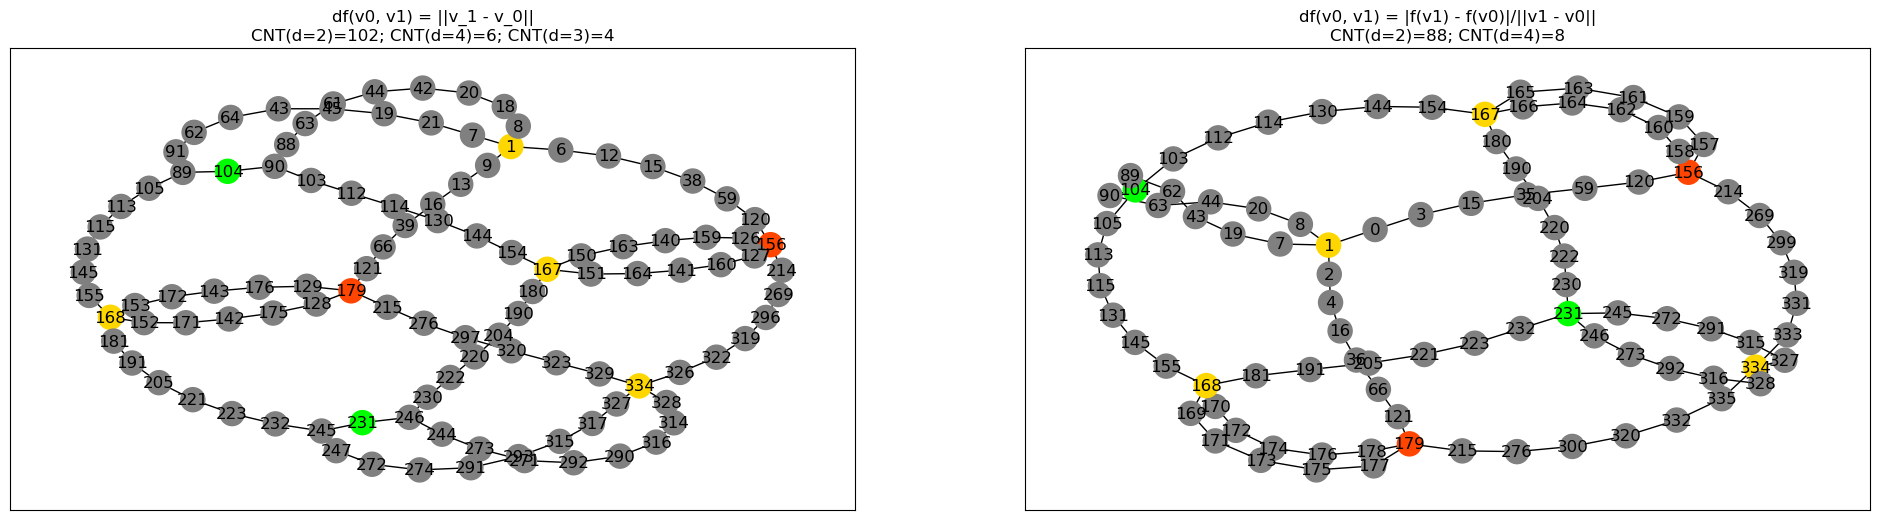

In [15]:
fig, axs = plt.subplots(1, len(grad_path_graphs), figsize=(24, 6))

for i, (key, graph) in enumerate(grad_path_graphs.items()):
    graph_is_planar = nx.is_planar(graph)
    degree_counts = dict(pd.Series(dict(graph.degree())).value_counts())
    degree_counts = '; '.join([f'CNT(d={degree})={cnt}' for degree, cnt in degree_counts.items()])

    axs[i].set_title(f'{key}\n{degree_counts}')
    pos = nx.kamada_kawai_layout(graph)
    node_color = gradient_dfs[key].loc[list(graph.nodes())]['type'].apply(lambda t: vertex_type_colors_dict[t])
    nx.draw_networkx(graph, pos=pos, node_color=node_color, ax=axs[i])

In [16]:
import pyvista as pv

p = pv.Plotter(shape=(len(gradient_functions), 2), window_size=(1200, len(gradient_functions)*500))

for i, gradient_title in enumerate(gradient_functions.keys()):
    df_points = gradient_dfs[gradient_title]
    path_lines = df_paths[df_paths['gradient'] == gradient_title]['line'].values
    path_colors = df_paths[df_paths['gradient'] == gradient_title]['color'].values

    p.subplot(i, 0)
    p.add_text(gradient_title, font_size=12)
    p.add_mesh(mesh, scalars="values", cmap="viridis", smooth_shading=False, show_edges=True)
    for type_name in ['min', 'saddle', 'max']:
        color = vertex_type_colors_dict[type_name]
        points = np.array(list(df_points[df_points['type'] == type_name]['pos'].values))
        p.add_points(points, color=color, point_size=12, render_points_as_spheres=True)
    for line in path_lines:
        p.add_mesh(pv.lines_from_points(line), color="white", line_width=4)

    p.subplot(i, 1)
    p.add_text(gradient_title, font_size=12)
    p.add_mesh(mesh, color='white', smooth_shading=False, show_edges=True)
    for type_name in ['min', 'saddle', 'max']:
        color = vertex_type_colors_dict[type_name]
        points = np.array(list(df_points[df_points['type'] == type_name]['pos'].values))
        p.add_points(points, color=color, point_size=12, render_points_as_spheres=True)
    for line, color in zip(path_lines, path_colors):
        p.add_mesh(pv.lines_from_points(line), color=color, line_width=8)

p.link_views()
p.show()


Widget(value='<iframe src="http://localhost:33755/index.html?ui=P_0x7e42e93f0cd0_1&reconnect=auto" class="pyvi…

## Removing Paths Solution

In [17]:
morse_function = lambda v: f(vertices[v])

gradient_function = lambda v0, v1: abs(morse_function(v0) - morse_function(v1))#/np.linalg.norm(vertices[v1] - vertices[v0], axis=-1)

In [18]:
df_points = pd.DataFrame({'vertex': np.unique(faces), 'pos':list (vertices)})

df_points['upper_vertices'] = df_points['vertex'].apply(lambda vertex: get_next_vertices(vertex, faces, f=morse_function, f_grad=gradient_function, direction_up=True))
df_points['lower_vertices'] = df_points['vertex'].apply(lambda vertex: get_next_vertices(vertex, faces, f=morse_function, f_grad=gradient_function, direction_up=False))
df_points['upper_cnt'] = df_points['upper_vertices'].apply(len)
df_points['lower_cnt'] = df_points['lower_vertices'].apply(len)

df_points['type'] = df_points.apply(get_vertex_type_row, axis=1)

print(f'df_points.shape = {df_points.shape}')
df_points.head()

df_points.shape = (336, 7)


,vertex,pos,upper_vertices,lower_vertices,upper_cnt,lower_cnt,type
0,0,"[-3.0, -0.8000000000000005, 9.797174393178831e...",[3],[7],1,1,regular
1,1,"[-3.0, 0.0, 0.0]","[2, 0]","[8, 7]",2,2,saddle
2,2,"[-3.0, 0.8000000000000005, 0.0]",[4],[8],1,1,regular
3,3,"[-2.8977774788672046, -1.5764571353075634, 1.9...",[15],[0],1,1,regular
4,4,"[-2.8977774788672046, 1.5764571353075634, 0.0]",[16],[2],1,1,regular


In [19]:
graph_decreasing = nx.DiGraph()
for irow, row in df_points.iterrows():
    v0 = row['vertex']
    edges = np.array([(v0, v1) for v1 in row['lower_vertices']])
    if len(edges) > 0:
        weights = gradient_function(edges[:, 0], edges[:, 1]).reshape(-1)
        edge_list = [(int(u), int(v), {"weight": float(w)}) for (u, v), w in zip(edges, weights)]
        graph_decreasing.add_edges_from(edge_list)
    
    edges = np.array([(v1, v0) for v1 in row['upper_vertices']])
    if len(edges) > 0:
        weights = gradient_function(edges[:, 0], edges[:, 1]).reshape(-1)
        edge_list = [(int(u), int(v), {"weight": float(w)}) for (u, v), w in zip(edges, weights)]
        graph_decreasing.add_edges_from(edge_list)
graph_increasing = graph_decreasing.reverse(copy=True)

In [20]:
paths = []
for saddle in df_points[df_points['type'] == 'saddle']['vertex']:
    for col_name in ['upper_vertices', 'lower_vertices']:
        for second_point in df_points.loc[saddle, col_name]:
            path = [saddle, second_point]
            while len(df_points.loc[path[-1], col_name]) == 1:
                path.append(df_points.loc[path[-1], col_name][0])
            if len(df_points.loc[path[-1], col_name]) != 0:
                print(f'Warning: {path[-1]} -> {df_points.loc[path[-1], col_name]}')
            paths.append(np.array(path))

df_paths = pd.DataFrame({'gradient_path': paths})
df_paths['start'] = df_paths['gradient_path'].apply(lambda path: path[0])
df_paths['second'] = df_paths['gradient_path'].apply(lambda path: path[1])
df_paths['finish'] = df_paths['gradient_path'].apply(lambda path: path[-1])
df_paths['direction'] = df_points.loc[df_paths['finish'].values]['type'].values

graph_decreasing_cut = graph_decreasing.copy()
graph_increasing_cut = graph_increasing.copy()
shortest_paths = []
for irow, row in df_paths.iterrows():
    if row['direction'] == 'max':
        path = nx.shortest_path(graph_increasing_cut, row['second'], row['finish'], weight='weight')
    elif row['direction'] == 'min':
        path = nx.shortest_path(graph_decreasing_cut, row['second'], row['finish'], weight='weight')
    else:
        path = [np.nan]
    path = np.append(row['start'], path)
    #graph_increasing_cut.remove_nodes_from(path[1:-1])
    #graph_decreasing_cut.remove_nodes_from(path[1:-1])

    shortest_paths.append(path)
df_paths['shortest_path'] = shortest_paths



df_paths

,gradient_path,start,second,finish,direction,shortest_path
0,"[1, 2, 4, 16, 36, 66, 121, 179]",1,2,179,max,"[1, 2, 4, 16, 36, 66, 121, 179]"
1,"[1, 0, 3, 15, 35, 59, 120, 156]",1,0,156,max,"[1, 0, 3, 15, 35, 59, 120, 156]"
2,"[1, 8, 20, 44, 63, 90, 104]",1,8,104,min,"[1, 8, 20, 44, 63, 90, 104]"
3,"[1, 7, 19, 43, 62, 89, 104]",1,7,104,min,"[1, 7, 19, 43, 62, 89, 104]"
4,"[167, 165, 163, 161, 159, 157, 156]",167,165,156,max,"[167, 165, 163, 161, 159, 157, 156]"
5,"[167, 166, 164, 162, 160, 158, 156]",167,166,156,max,"[167, 166, 164, 162, 160, 158, 156]"
6,"[167, 154, 144, 130, 114, 112, 103, 104]",167,154,104,min,"[167, 154, 144, 130, 114, 112, 103, 104]"
7,"[167, 180, 190, 204, 220, 222, 230, 231]",167,180,231,min,"[167, 180, 190, 204, 220, 222, 230, 231]"
8,"[168, 170, 172, 174, 176, 178, 179]",168,170,179,max,"[168, 170, 172, 174, 176, 178, 179]"
9,"[168, 169, 171, 173, 175, 177, 179]",168,169,179,max,"[168, 169, 171, 173, 175, 177, 179]"


In [21]:
df_paths[['gradient_path', 'shortest_path']].map(len)

,gradient_path,shortest_path
0,8,8
1,8,8
2,7,7
3,7,7
4,7,7
5,7,7
6,8,8
7,8,8
8,7,7
9,7,7


In [22]:
path_length = lambda path: gradient_function(path[:-1], path[1:]).sum() if not np.isnan(path).any() else None

df_paths[['gradient_path', 'shortest_path']].map(path_length)

,gradient_path,shortest_path
0,0.8,0.8
1,0.8,0.8
2,2.0,2.0
3,2.0,2.0
4,2.0,2.0
5,2.0,2.0
6,0.8,0.8
7,0.8,0.8
8,2.0,2.0
9,2.0,2.0


In [23]:
full_graph = nx.Graph()
full_graph.add_edges_from(np.unique(np.sort(faces[:, [[0, 1], [0, 2], [1, 2]]].reshape(-1, 2), axis=1), axis=0))


def get_decreasing_graph(graph: nx.Graph(), morse_function):
    forest = nx.DiGraph()
    for node in graph.nodes():
        node_val = morse_function(node)
        neighbors = np.array(list(graph.neighbors(node)))
        neighbors_vals = morse_function(neighbors)
        if (neighbors_vals < node_val).any():
            next_node = neighbors[np.argmin(neighbors_vals)]
            forest.add_edge(node, next_node)
    return forest

decreasing_graph = get_decreasing_graph(full_graph, morse_function)
increasing_graph = get_decreasing_graph(full_graph, morse_function=lambda v: -morse_function(v))



In [24]:
decreasing_segments = list(nx.connected_components(decreasing_graph.to_undirected()))
increasing_segments = list(nx.connected_components(increasing_graph.to_undirected()))
intersected_segments = [np.intersect1d(list(s0), list(s1)) for s0, s1 in itertools.product(decreasing_segments, increasing_segments)]
intersected_segments = [s for s in intersected_segments if len(s) > 0]

print(f'decreasing_segments lengths: {[len(s) for s in decreasing_segments]}, total: {np.sum([len(s) for s in decreasing_segments])}')
print(f'increasing_segments lengths: {[len(s) for s in increasing_segments]}, total: {np.sum([len(s) for s in increasing_segments])}')
print(f'intersected_segments lengths: {[len(s) for s in intersected_segments]}, total: {np.sum([len(s) for s in intersected_segments])}')

decreasing_segments lengths: [174, 162], total: 336
increasing_segments lengths: [170, 166], total: 336
intersected_segments lengths: [87, 87, 83, 79], total: 336


In [25]:
p = pv.Plotter(shape=(1, 3), window_size=(1200, 500))

for i, (segments, title) in enumerate(zip([decreasing_segments, increasing_segments, intersected_segments], 
                                          ['decreasing segments', 'increasing segments', 'segment intersection'])):
    p.subplot(0, i)
    p.add_text(title, font_size=12)

    vertex_segment = -np.ones(mesh.points.shape[0], dtype=int)
    for i_segment, segment in enumerate(segments):
        vertex_segment[list(segment)] = i_segment

    #mesh.point_data[title] = vertex_segment

    mesh_faces = mesh.faces.reshape(-1, 4)[:, 1:]  # triangles: (n_cells, 3)
    face_segment = -np.ones(mesh.n_cells, dtype=int)
    for i_segment, segment in enumerate(segments):
        segment = set(segment)
        for i_cell, face in enumerate(mesh_faces):
            if set(face).issubset(segment):
            #if len(set(face) & segment) >= 2:
                face_segment[i_cell] = i_segment

    mesh.cell_data[title] = face_segment


    p.add_mesh(mesh, scalars=title, cmap="tab10", categories=True, smooth_shading=False, show_edges=True)

    for type_name in ['min', 'saddle', 'max']:
        color = vertex_type_colors_dict[type_name]
        points = np.array(list(df_points[df_points['type'] == type_name]['pos'].values))
        p.add_points(points, color=color, point_size=12, render_points_as_spheres=True)


p.link_views()
p.show()

Widget(value='<iframe src="http://localhost:33755/index.html?ui=P_0x7e42e93f39d0_2&reconnect=auto" class="pyvi…

In [26]:
mesh

PolyData (0x7e4312e7a1a0)
  N Cells:    672
  N Points:   336
  N Strips:   0
  X Bounds:   -3.000e+00, 3.000e+00
  Y Bounds:   -3.800e+00, 3.800e+00
  Z Bounds:   -1.000e+00, 1.000e+00
  N Arrays:   4

In [27]:
faces

array([[335, 332, 324],
       [335, 324, 330],
       [324, 308, 318],
       ...,
       [ 42,  20,  18],
       [ 18,   8,   6],
       [  6,   1,   0]], shape=(672, 3))